# Nuclear Engineering 204 Lab 1 Notebook

## Functions all defined in "NE204_Functions.py" in the directory above

In [1]:
import sys
sys.path.insert(0, '../')
from NE204_Functions import *

plt.rcParams['figure.dpi'] = 300

source_colors = {'Co57': 'red', 'Co60': 'orange', 'Cs137': 'gold', 
                 'Eu152': 'green', 'Th228': 'blue', 'Background': 'purple'}

# Information of sources that were used for data collection
#              'Source_Name': [Production_Date, Measurement_Date, Half-Life(yrs), 
#               Production_Activity, Measurement_Time(min)]
source_info = {'Cs137': ['10/15/2020', '9/28/2022', 30.08, 0.01e-3, 2],
               'Co57': ['10/15/2020', '9/28/2022', 0.7445, 0.01e-3, 2],
               'Co60': ['10/15/2020', '9/28/2022', 5.2747, 0.01e-3, 2],
               'Th228': ['10/1/2013', '10/11/2022', 1.9116, 10.93e-6, 60],
               'Eu152': ['3/15/2012', '10/11/2022', 13.517, 9.496e-6, 5],
               'Background': [None, '10/12/2022', None, None, 60]}

Plots directory already exists


## Cs-137 Test Data Resolution as a function of Peaking and Gap Time

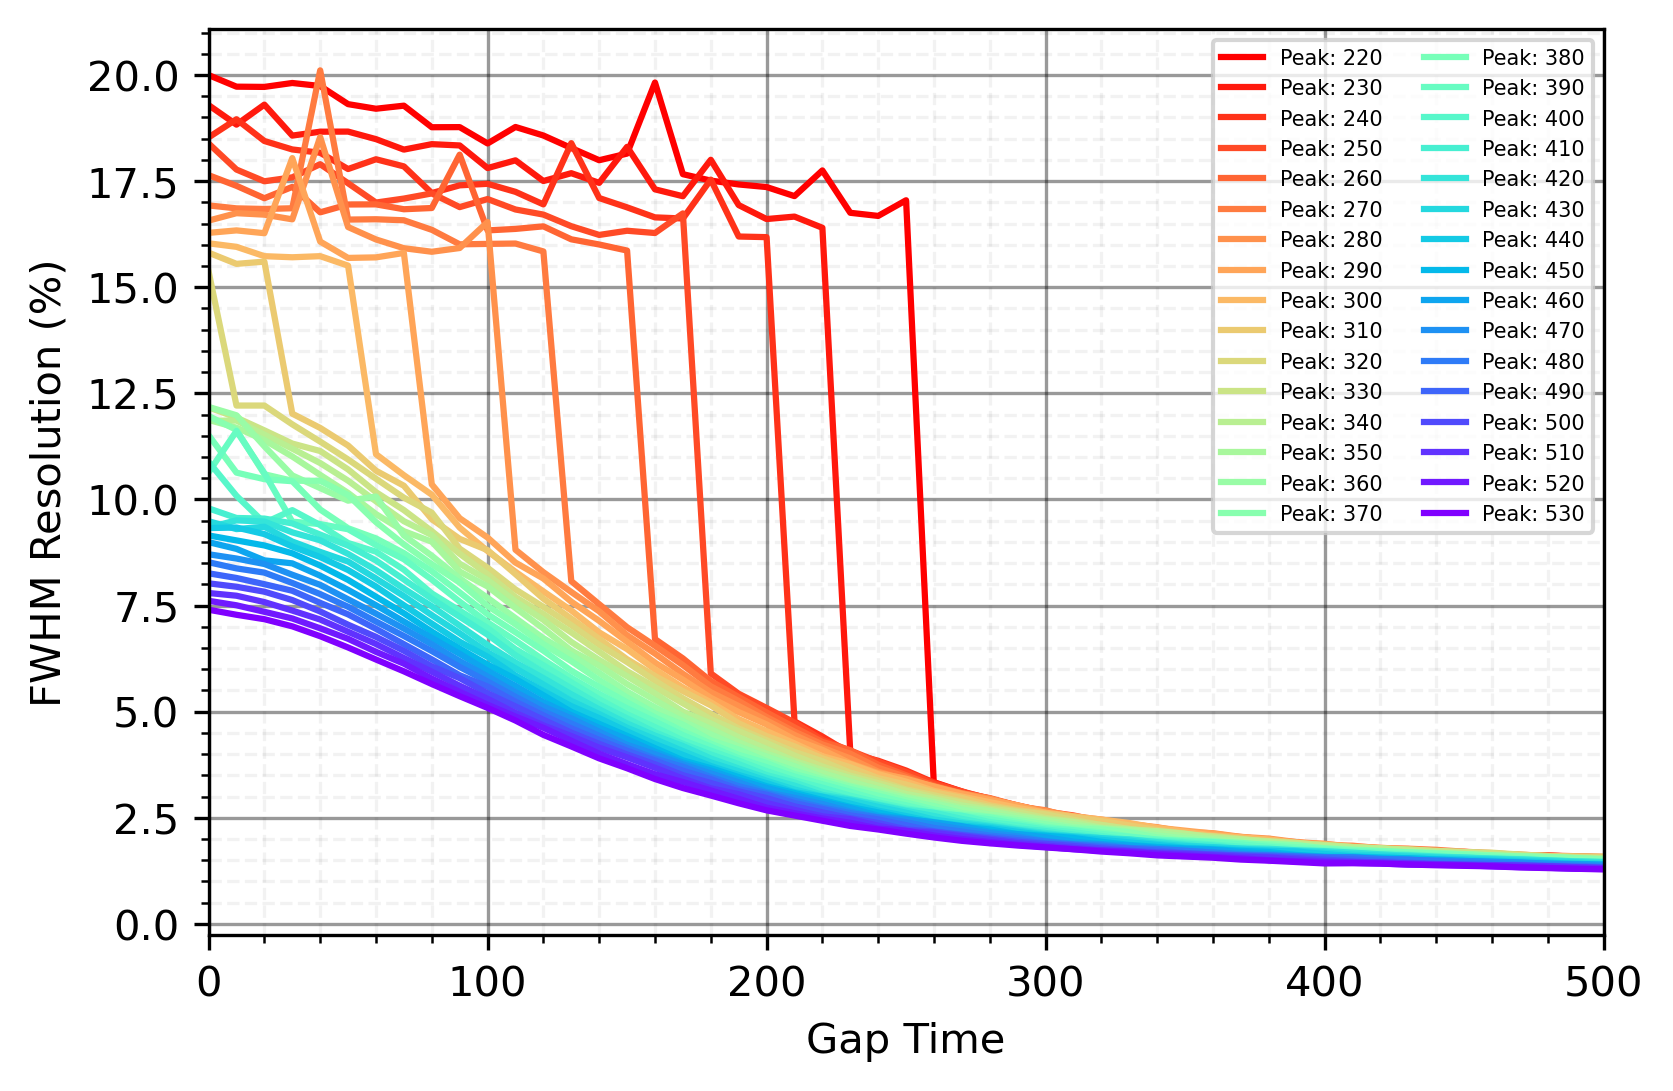

In [317]:
files = [[int(f.split('p')[1][:3]), 'Cs137-Test-Fits/Fits/'+f] for f in os.listdir('Cs137-Test-Fits/Fits/')]
files.sort()

cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(1, 0, len(files)))

gs = list(range(0,510,10))+list(range(600, 10100, 100))

plt.figure(dpi=300)
for i, file in enumerate(files):
    gfr = np.load(file[1])
    
    resolutions = np.abs(((gfr[:,3]*2.35482)/gfr[:,2])*100)
    
    plt.plot(gs[:len(resolutions)], resolutions, label='Peak: {}'.format(file[0]), color=colors[i])
plt.legend(fontsize=5, ncol=2)
plt.xlabel('Gap Time')
plt.ylabel('FWHM Resolution (%)')
plt.grid(which='major', color='k', linestyle='-', alpha=0.4)
plt.minorticks_on()
plt.grid(which='minor', color='k', linestyle='--', alpha=0.05)
plt.xlim(0,500)
#plt.ylim(1.3,2)
plt.savefig('Plots/cs137_resolution_optimization.png', dpi=300, bbox_inches='tight', facecolor='white')

plt.show()

## Calibration Curve for (peak=500, gap=2500)

In [3]:
energy_calibrations = {'Energies': np.array([121.7817, 244.6974, 661.657, 1173.228, 1332.492, 
                                             1408.013, 2614.511]),
                      'Trapezoid Heights': np.array([20463.94, 41013.587, 110939.958, 196794.348, 223511.721,
                                           236469.213, 439098.653]),
                      'Sigmas': np.array([334.753, 361.740, 427.465, 478.823, 506.812, 577.748, 703.456])}

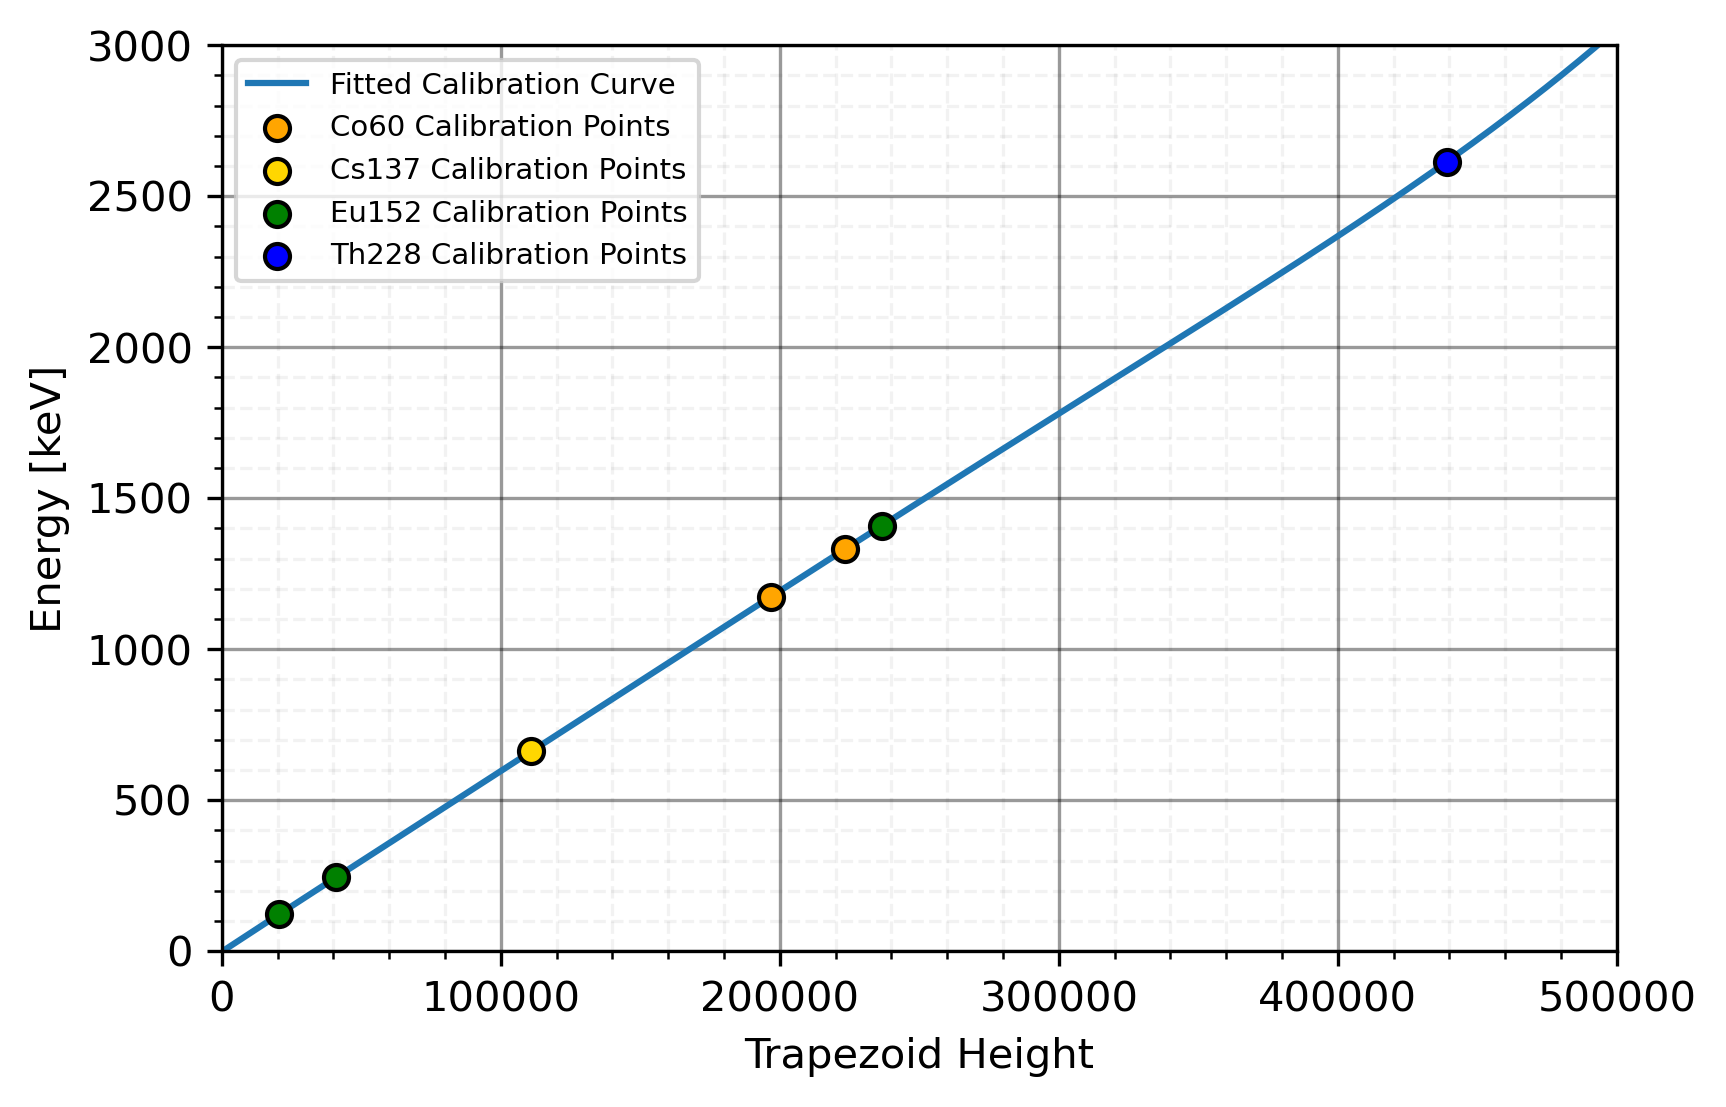

In [4]:
plt.plot(calibrate_energy(np.arange(5e5),*calib_consts), label='Fitted Calibration Curve')#, zorder=-1)
plt.scatter(energy_calibrations['Trapezoid Heights'][[3,4]], energy_calibrations['Energies'][[3,4]], 
            label='Co60 Calibration Points', color=source_colors['Co60'], zorder=5, edgecolor='black')
plt.scatter(energy_calibrations['Trapezoid Heights'][[2]], energy_calibrations['Energies'][[2]], 
            label='Cs137 Calibration Points', color=source_colors['Cs137'], zorder=5, edgecolor='black')
plt.scatter(energy_calibrations['Trapezoid Heights'][[0,1,5]], energy_calibrations['Energies'][[0,1,5]], 
            label='Eu152 Calibration Points', color=source_colors['Eu152'], zorder=5, edgecolor='black')
plt.scatter(energy_calibrations['Trapezoid Heights'][[-1]], energy_calibrations['Energies'][[-1]], 
            label='Th228 Calibration Points', color=source_colors['Th228'], zorder=5, edgecolor='black')
plt.xlim(0,5e5)
plt.ylim(0,3000)
plt.legend(fontsize=7)
plt.grid(which='major', color='k', linestyle='-', alpha=0.4)
plt.minorticks_on()
plt.grid(which='minor', color='k', linestyle='--', alpha=0.05)
plt.xlabel("Trapezoid Height")
plt.ylabel('Energy [keV]')
plt.savefig('Plots/calibration_curve.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Creation of Spectra

## Combining Datafiles

In [20]:
uncombined_dir = 'Data/Combined_Data/Uncombined_Data/'
uncombined_source = 'Cs137'
uncombined_data = [uncombined_dir+f for f in os.listdir(uncombined_dir) if f != '.DS_Store' and uncombined_source in f]

file_name = '-'.join(uncombined_data[0].split('/')[-1].split('_')[0].split('-')[:-1])

datas = []
for i, file in enumerate(tqdm(uncombined_data, desc='Combining Files')):
    f = h5py.File(file, 'r')
    data_np = np.array(f['raw_data'])
    time_event, unique_times = np.unique(np.array(f['event_data']['timestamp']), return_index=True)
    
    data_np_crop = data_np[unique_times]
    
    datas.append(data_np_crop)
merge_data = np.concatenate(datas)

fmerged = h5py.File('Data/Combined_Data/{}-{}.h5'.format(file_name, i+1), 'w')
fmerged.create_dataset('raw_data', data=merge_data)

fmerged.close()

Combining Files:   0%|          | 0/2 [00:00<?, ?it/s]

## Importing Data and Calibration constants

In [27]:
filepath = 'Data/Combined_Data/'
files = ['Cs137-24in-2.h5', 'Co57-4in-2.h5', 'Co60-36in-2.h5', 
        'Th228-24in-60.h5', 'Eu152-24in-5.h5', 'Background-60.h5']

data, sat_i = import_data(filepath+files[0])

## Looping through pulses and shaping, fitting and calculating pulse height

In [87]:
peak, gap = 500, 2500 # set as defaults to this in "calibrate_pulses"
max_height = 493154

energies = calibrate_pulses(data, save_file='Background-Cal')

Creating spectra:   0%|          | 0/20098 [00:00<?, ?it/s]

Saving trapezoid heights


### Pre-Calculated Trapezoids

In [2]:
filepath_traps = 'Data/Trapezoid_Heights/'
files_traps = ['Co57-Cal.npy', 'Co60-Cal.npy', 'Cs137-Cal.npy', 'Eu152-Cal.npy', 'Th228-Cal.npy', 'Background-Cal.npy']
files_traps = [filepath_traps+f for f in files_traps]

In [4]:
energies = np.load(files_traps[2])

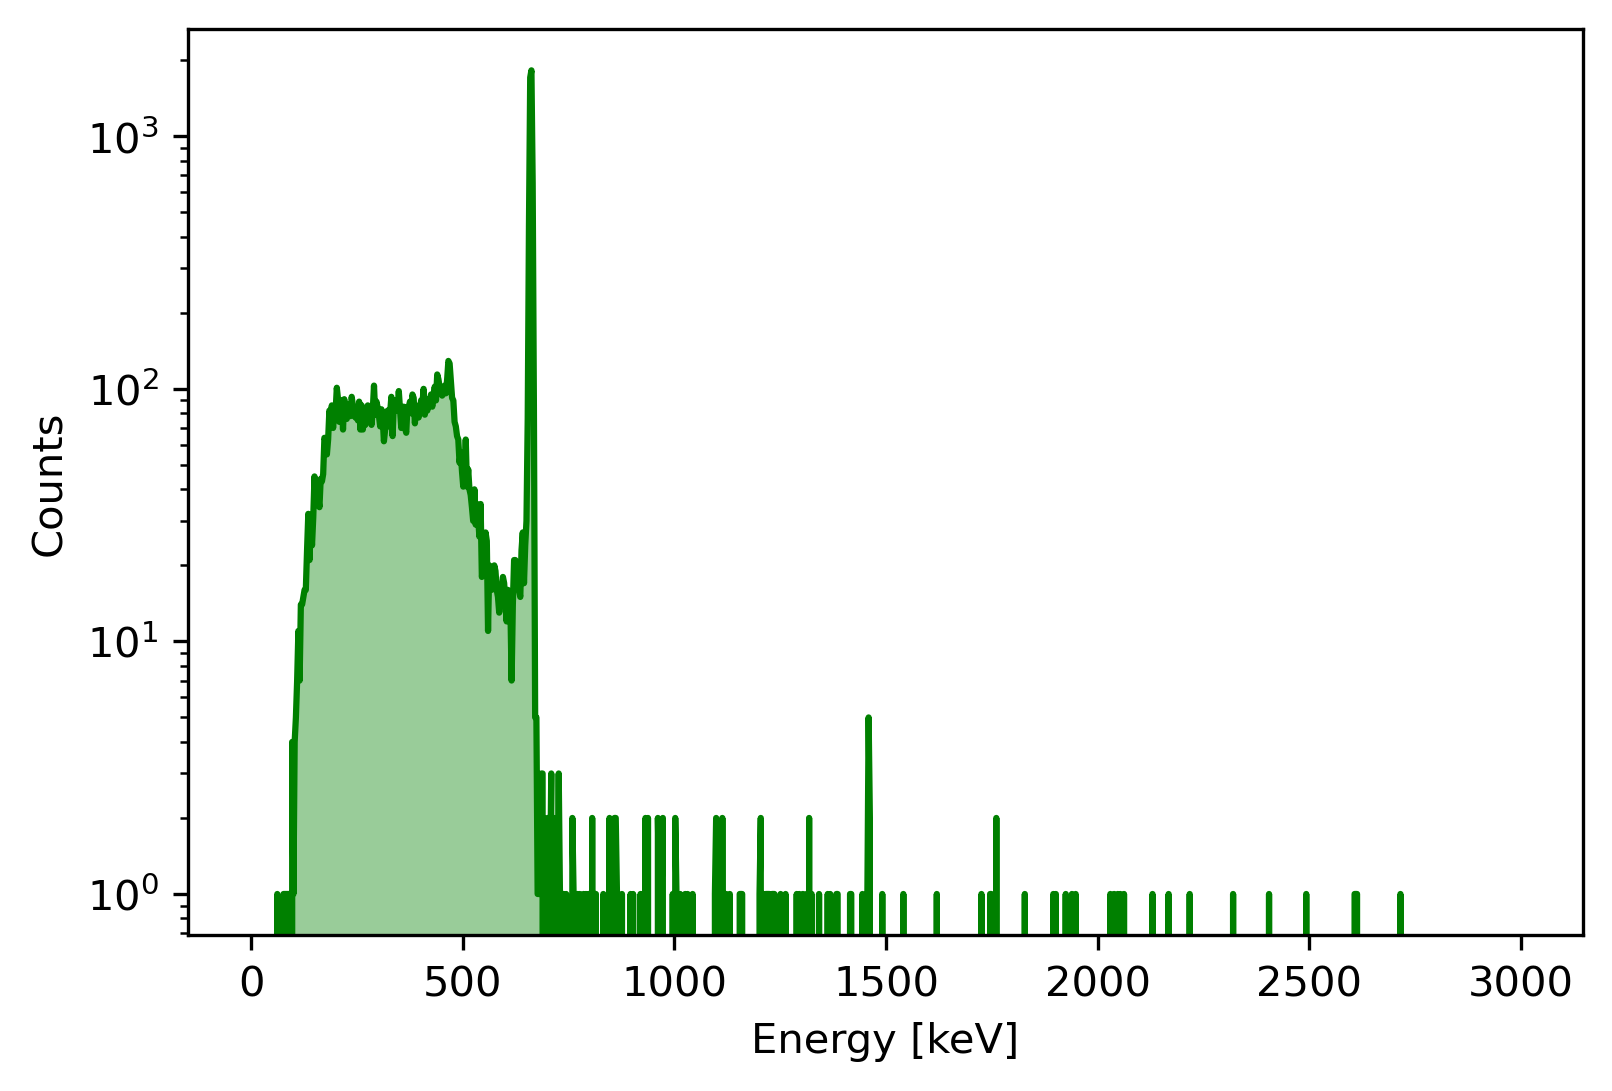

In [267]:
bins_ = np.linspace(0, 3000, 2**10+1)
#bins_ = np.linspace(0, 6e5, 2**10+1)
counts, bins_out, patches = plt.hist(energies, bins=bins_, alpha=0.5, color='b')
plt.close()
#plt.xlim(2500, 2700)
plt.plot(bins_[:-1], counts, color='green')
plt.fill_between(bins_[:-1], counts, facecolor='green', alpha=0.4)
plt.semilogy()
plt.xlabel('Energy [keV]')
plt.ylabel('Counts')
#plt.title('Th228, 1hour')
#plt.xlim(2000, 3000)
plt.show()

### Plotting all 6 Source Spectra together

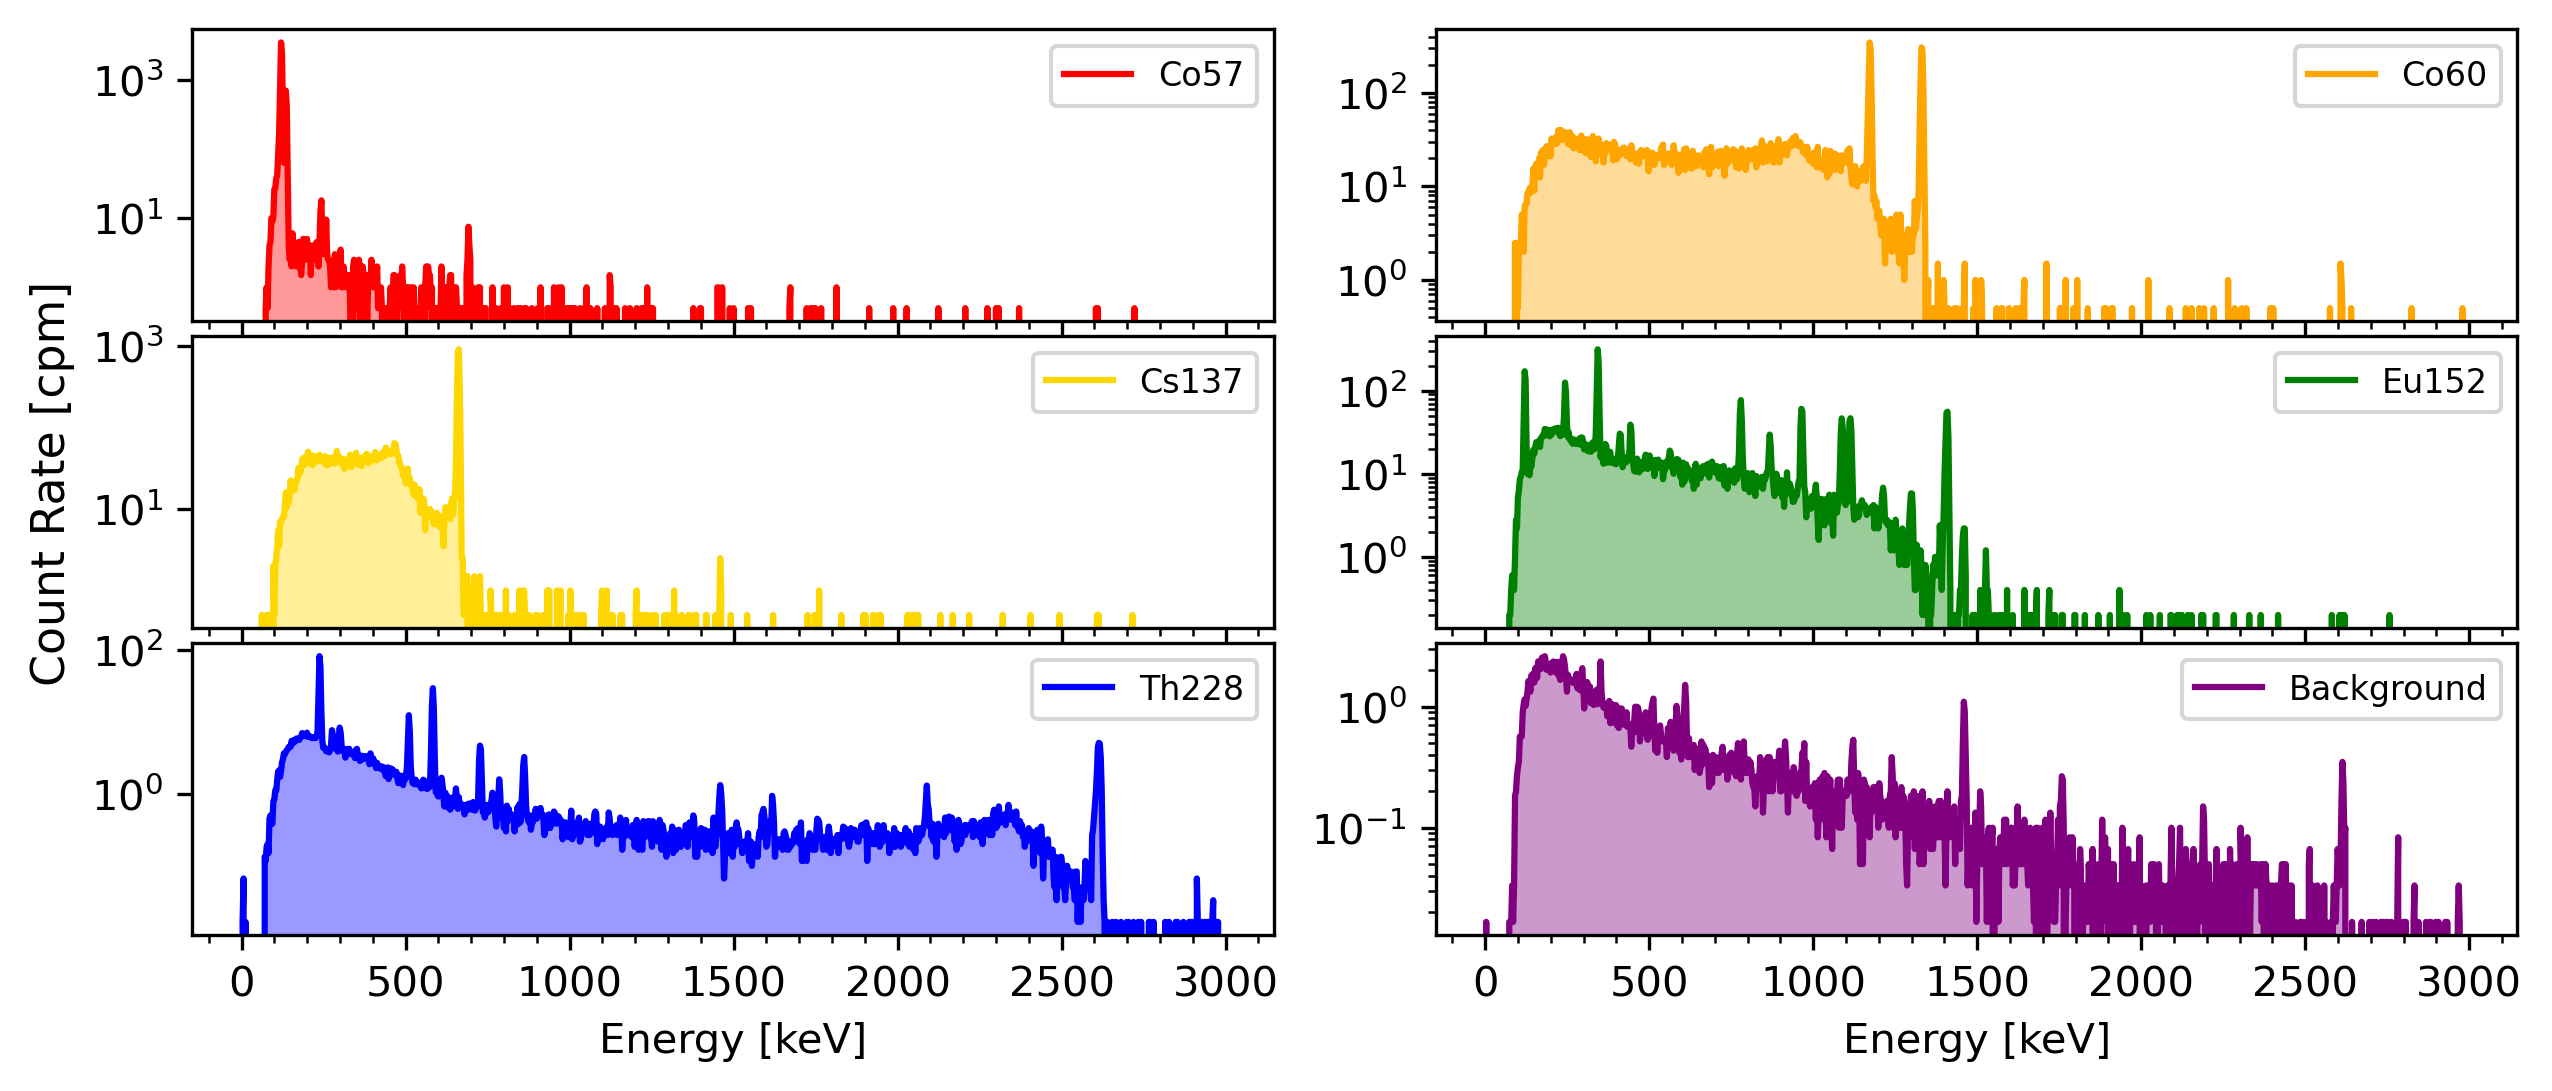

In [25]:
bins_ = np.linspace(0, 3000, 2**10+1)
counts_all, sources = [], []
for file in files_traps:
    energies = np.load(file)
    counts, bins_outs, _ = plt.hist(energies, bins=bins_)
    plt.close()
    counts_all.append(counts)
    sources.append(file.split('.')[0].split('/')[-1].split('-')[0])
counts_all = np.array(counts_all)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex='all', figsize=(10, 4))
axes = (ax1, ax2, ax3, ax4, ax5, ax6)
for c, ca in enumerate(counts_all):
    ca = ca/source_info[sources[c]][4]
    axes[c].plot(bins_[:-1], ca, label=sources[c], color=source_colors[sources[c]])
    axes[c].semilogy()
    axes[c].legend(fontsize=8)
    axes[c].fill_between(bins_[:-1], ca, facecolor=source_colors[sources[c]], alpha=0.4)
    axes[c].minorticks_on()
ax3.set_ylabel('Count Rate [cpm]', fontsize=11)
ax5.set_xlabel('Energy [keV]', fontsize=10)
ax6.set_xlabel('Energy [keV]', fontsize=10)
plt.subplots_adjust(wspace=0.15, hspace=0.05)
#plt.tight_layout()
plt.savefig('Plots/All_Spectra-new.png', bbox_inches='tight', facecolor='white')
plt.show()

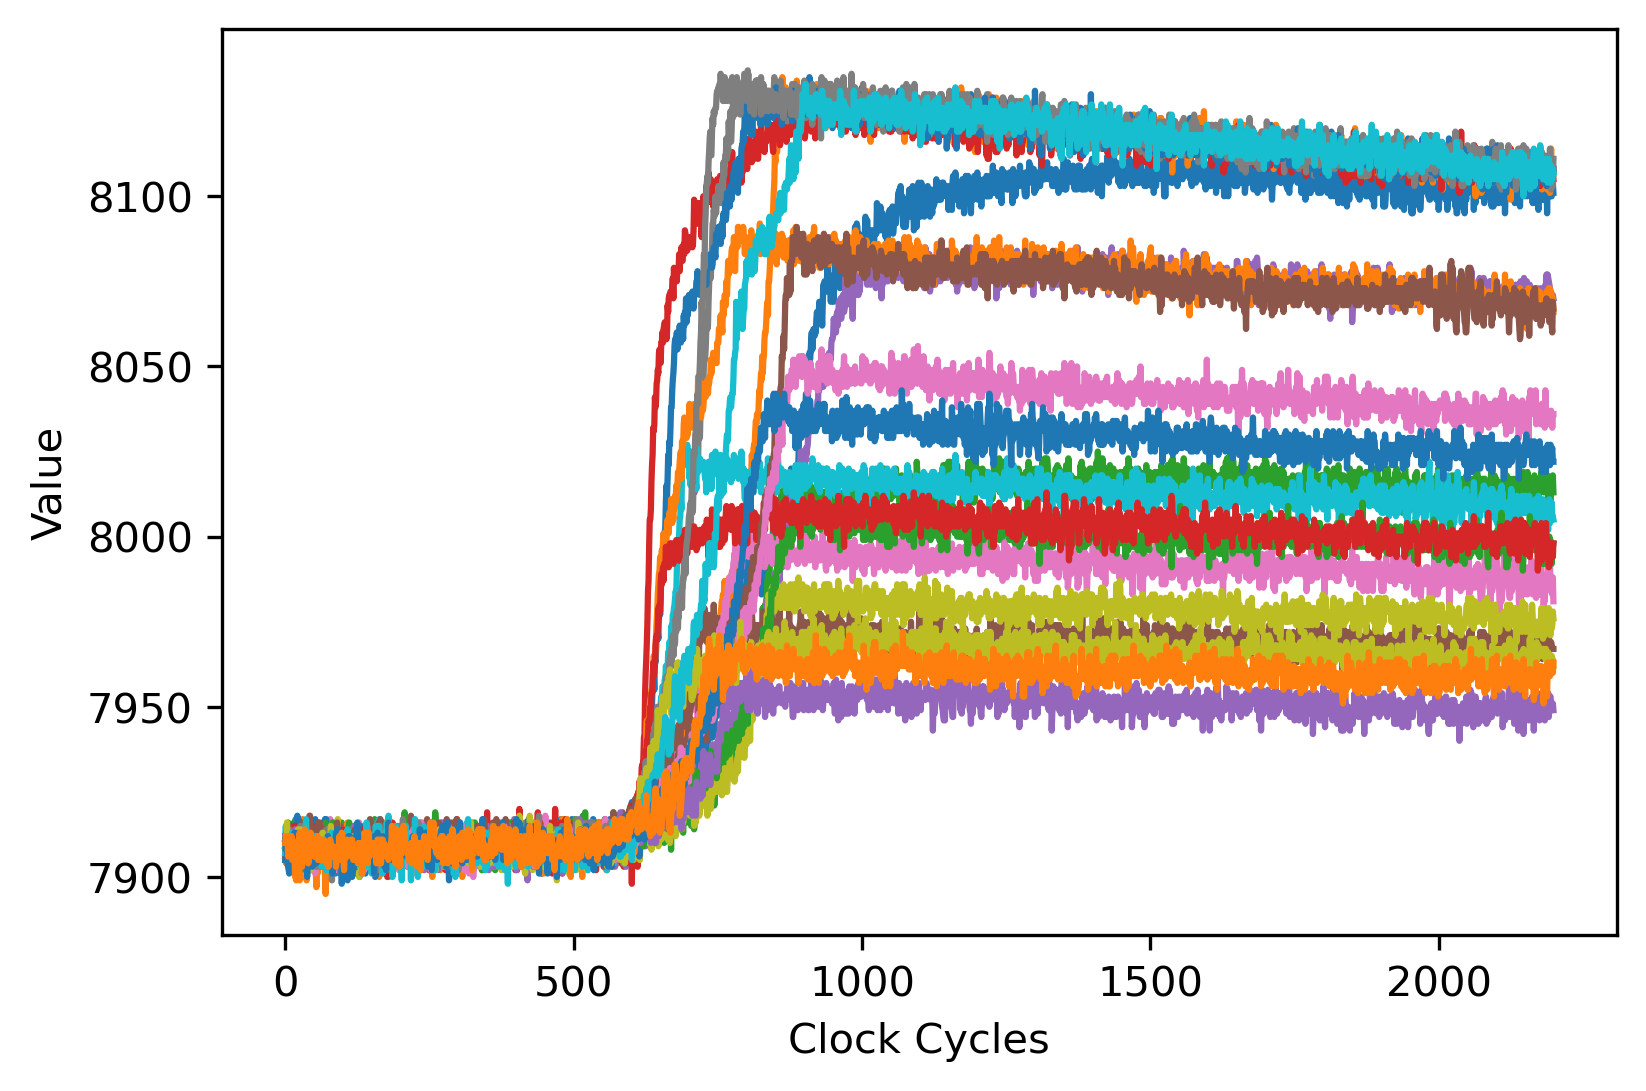

In [31]:
for p in range(len(data)):
    if max(data[p]) < 8500:
        plt.plot(data[p][determine_rise(savgol_filter(data[p], 51, 0))-500:determine_rise(savgol_filter(data[p], 51, 0))+1700])
    if p > 20:
        break
plt.xlabel('Clock Cycles')
plt.ylabel('Value')
plt.savefig('Plots/sample_pulses.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

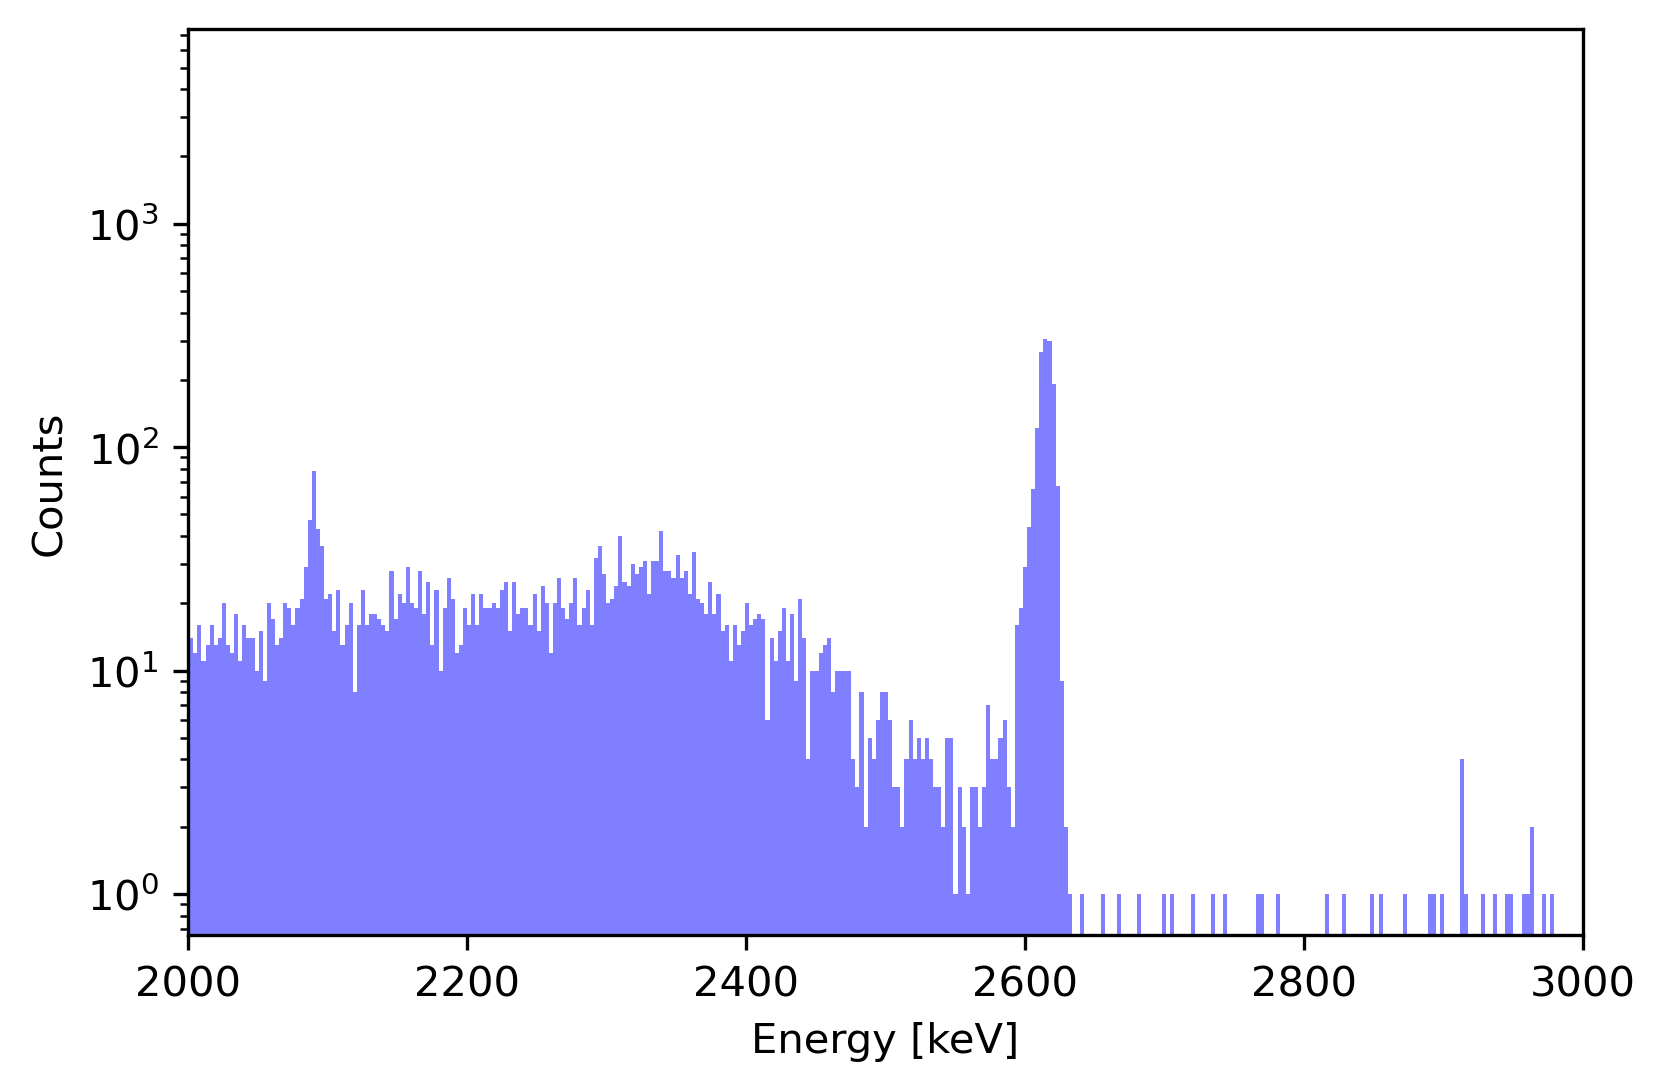

In [165]:
plt.figure(dpi=300)
bins_ = np.linspace(0, 3000, 2**10+1)
#bins_ = np.linspace(0, 6e5, 2**10+1)
counts, bins_out, patches = plt.hist(energies, bins=bins_, alpha=0.5, color='b')
#plt.xlim(2500, 2700)
plt.semilogy()
plt.xlabel('Energy [keV]')
plt.ylabel('Counts')
#plt.title('Th228, 1hour')
plt.xlim(2000, 3000)
plt.show()

## Fitted Resolutions + Resolution vs. Energy

In [6]:
# Co57, Co60, Cs137, Eu152, Th228, Background
energies = np.load(files_traps[2])

Calculated resolution: 0.911%
Mean height: 661.7089090802676
Sigma: 2.5610430931961816


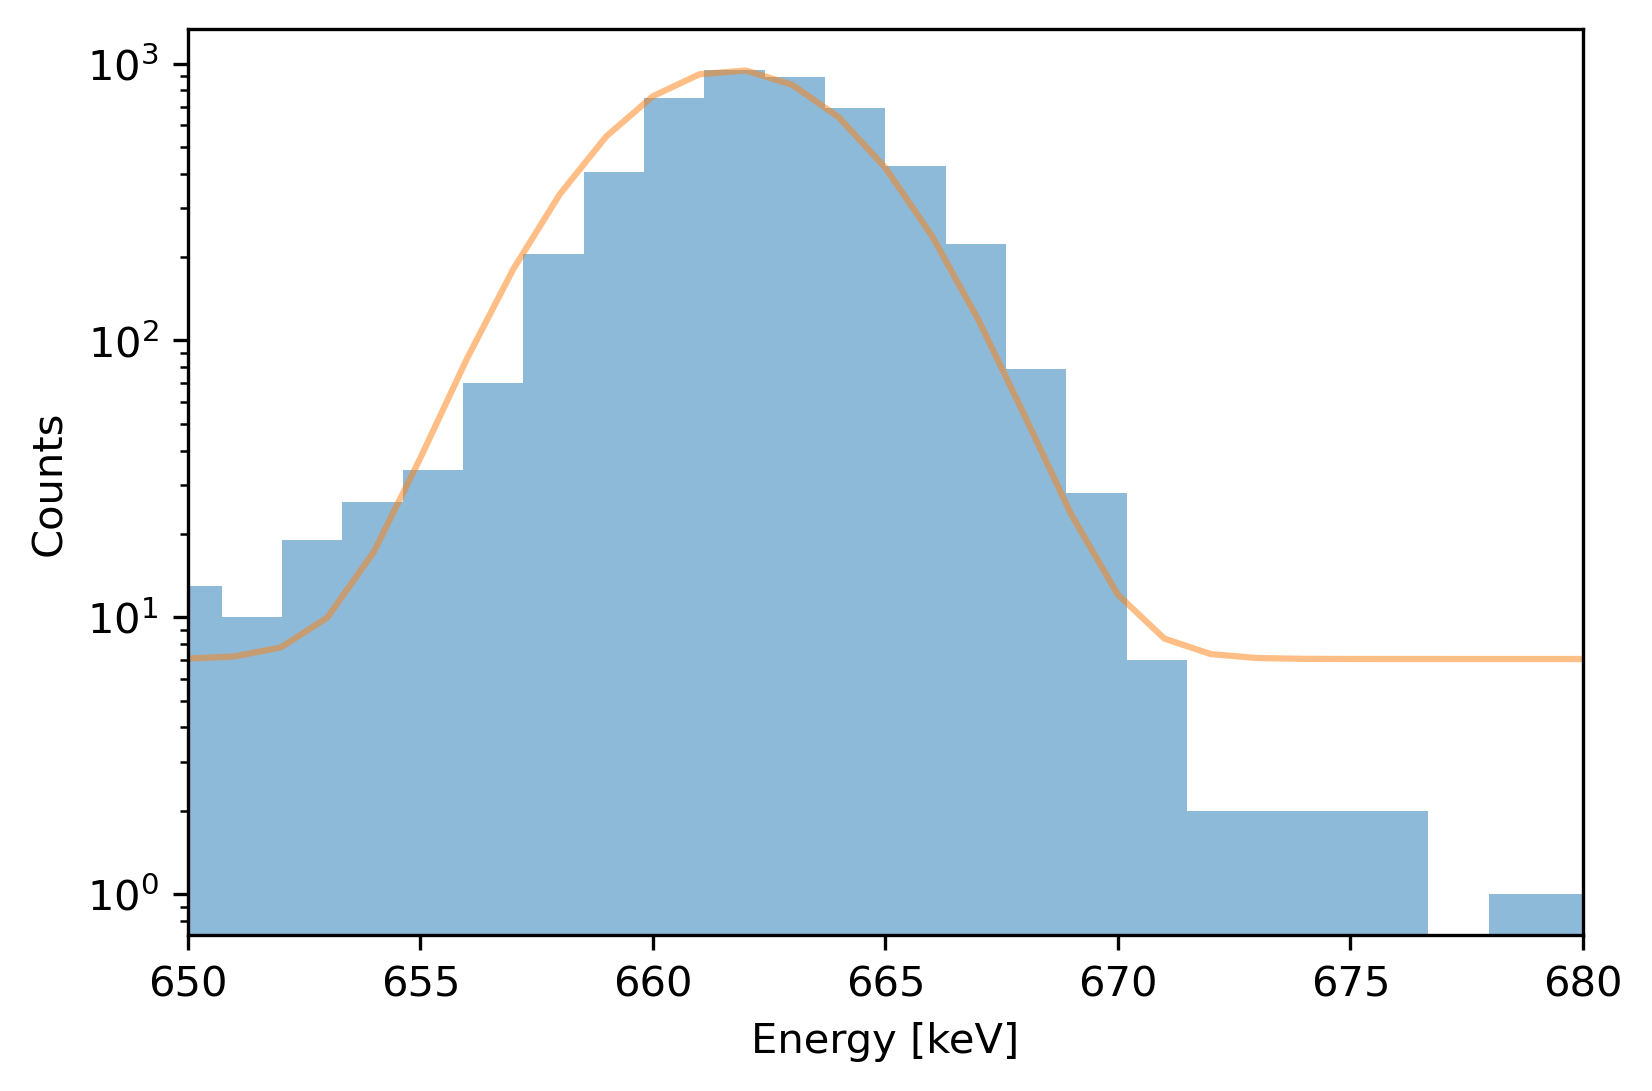

In [12]:
plt.figure(dpi=300)
counts, bins_out, patches = plt.hist(energies, bins=2**11, alpha=0.5, label='Max')

win_min, win_max = 650, 680
#win_min, win_max = 2.34e5, 2.39e5

start = np.argmin(np.abs(bins_out - win_min))
end = np.argmin(np.abs(bins_out - win_max))

gauss_result = gauss_fit(bins_out[start:end], counts[start:end])
print("Calculated resolution: {}%".format(round(np.abs(((gauss_result[3]*2.35482)/gauss_result[2])*100),3)))
print('Mean height: {}'.format(gauss_result[2]))
print('Sigma: {}'.format(gauss_result[3]))

plt.plot(gauss(np.arange(3000), *gauss_result), alpha=0.5)
plt.xlim(win_min, win_max)

#plt.plot(bins_out[:-1], counts, c='b')

# perr = np.sqrt(np.diag(pcov))

plt.xlabel('Energy [keV]')
plt.ylabel('Counts')
plt.semilogy()
plt.show()
#print("Calculated resolution fit: {}%".format(round(np.abs(((gauss_result2[3]*2.35482)/gauss_result2[2])*100),3)))

In [13]:
sum(gauss(np.arange(3000), *gauss_result)-gauss(np.arange(3000), *gauss_result)[0])

6060.244011644772

In [16]:
calc_activity(source_info['Cs137'])*120

42447016.300336085

In [19]:
6060/42447016/1e-3

0.14276621942046525

In [8]:
eu152_resolutions = {'Energies': np.array([121.960, 244.928, 344.414, 411.642, 444.229, 779.719, 868.333,
                                          965.513, 1088.182, 1113.588, 1213.733, 1299.746, 1408.541,
                                          1459.428, 1528.265]),
              'Sigmas': np.array([2.052, 2.036, 2.176, 2.874, 2.232, 2.592, 2.460, 2.922, 2.991, 3.190,
                                 2.591, 3.847, 3.356, 4.005, 2.735])}
cs137_resolutions = {'Energies': np.array([661.709]), 'Sigmas': np.array([2.566])}
co60_resolutions = {'Energies': np.array([1173.632, 1331.949]), 'Sigmas': np.array([2.873, 3.011])}
co57_resolutions = {'Energies': np.array([121.874, 136.154]), 'Sigmas': np.array([1.881, 1.987])}
th228_resolutions = {'Energies': np.array([238.894, 277.260, 300.166, 510.833, 583.660, 728.117, 861.526, 2614.570]), 
                     'Sigmas': np.array([2.126, 2.055, 2.507, 2.163, 2.506, 2.998, 2.814, 4.658])}
resolutions = {'Co57': co57_resolutions, 'Co60': co60_resolutions, 'Cs137': cs137_resolutions,
              'Eu152': eu152_resolutions, 'Th228': th228_resolutions}

all_ene = np.concatenate([resolutions[sou]['Energies'] for sou in resolutions])
all_sig = np.concatenate([resolutions[sou]['Sigmas'] for sou in resolutions])
sort_ene = np.argsort(all_ene)

all_ene = all_ene[sort_ene]
all_sig = all_sig[sort_ene]

In [35]:
def linear_line(x, m, b):
    return m*x + b
linear,_ = curve_fit(linear_line, np.sqrt(all_ene), all_sig*(2*np.sqrt(2*np.log(2))))

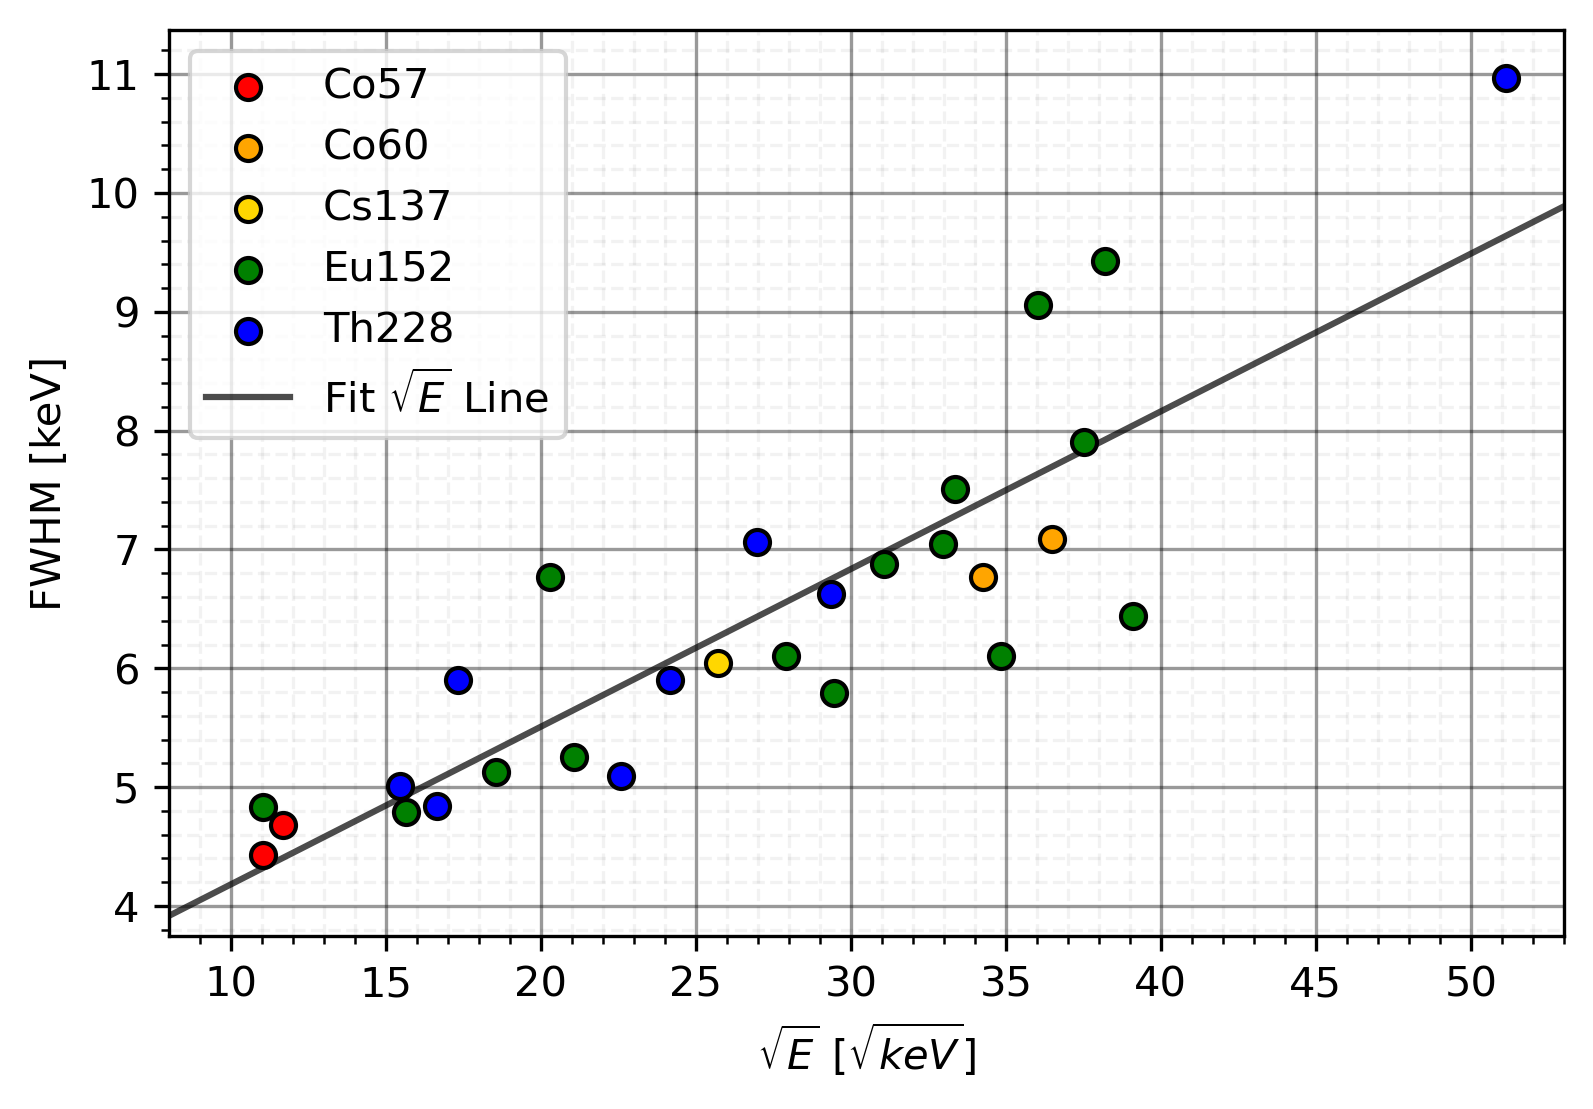

In [41]:
colors = ['red', 'orange', 'yellow', 'green', 'blue']
for r, source in enumerate(resolutions):
    plt.scatter(np.sqrt(resolutions[source]['Energies']), resolutions[source]['Sigmas']*(2*np.sqrt(2*np.log(2))), 
               color=source_colors[source], label='{}'.format(source), edgecolor='black', zorder=5)
plt.plot(linear_line(np.arange(60), *linear), color='black', label=r"Fit $\sqrt{E}$ Line", alpha=0.7)
plt.legend()
plt.grid(which='major', color='k', linestyle='-', alpha=0.4)
plt.minorticks_on()
plt.grid(which='minor', color='k', linestyle='--', alpha=0.05)
plt.xlim(8, 53)
plt.ylim(3.75)
plt.ylabel('FWHM [keV]')
plt.xlabel(r"$\sqrt{E}$ [$\sqrt{keV}$]")
plt.savefig('Plots/resolution_energy_dep.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()